📦 Import Required Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import utils
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Model

%matplotlib inline

⚙️ Parameters & Configuration

In [ ]:
base_image_path = "inputs/cat.jpg"
result_prefix = "cat_dream"

# Path to input image and prefix for saving results
layer_settings = {
    "mixed0": 0.5,
    "mixed2": 1.0,
    "mixed3": 1.5,
    "mixed5": 2.0,
}

# DeepDream hyperparameters
step = 0.02  # Gradient ascent step size
iterations = 30  # Number of gradient ascent iterations per octave
num_octave = 4  # How many scales (octaves) to run
octave_scale = 1.3  # Scale factor between octaves
max_loss = 8.0  # Prevents runaway loss for stability

🖼️ View Base Image

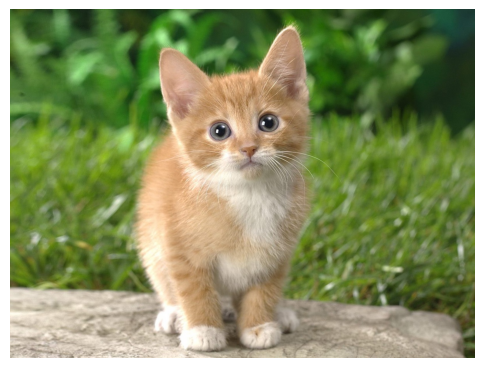

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(plt.imread(base_image_path))
plt.axis("off")
plt.show()

🔄 Preprocessing & Deprocessing Utilities

In [ ]:
def preprocess_image(image_path):
    """
    Load and preprocess the image for InceptionV3.
    - Converts to array
    - Adds batch dimension
    - Applies InceptionV3 preprocessing
    """
    img = utils.load_img(image_path)
    img = utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    """
    Convert a processed tensor back into a valid RGB image.
    - Undo InceptionV3 preprocessing
    - Clip values to [0, 255]
    """
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    x = np.clip(x, 0, 255).astype("uint8")
    return x

🤖 Load Pretrained Model & Feature Extractor

In [ ]:
# Load InceptionV3 pretrained on ImageNet (exclude classification head)
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Extract outputs of specific layers for dreaming
output_dicts = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Model that maps input → selected layer activations
feature_extractor = Model(inputs=model.inputs, outputs=output_dicts)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


📉 Define the Loss Function

In [ ]:
def compute_loss(input_image):
    """
    Compute DeepDream loss:
    - Forward pass through selected layers
    - Weighted sum of squared activations (excluding borders to reduce artifacts)
    """
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())  # Initialize total loss
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), dtype="float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

🔼 Gradient Ascent Loop (Single Octave)

In [ ]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    """
    Perform a single gradient ascent step:
    - Compute gradients of loss wrt image
    - Normalize gradients to avoid exploding updates
    - Update the image in the direction of maximum activation
    """
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    grads = tape.gradient(loss, img)
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)  # Normalize
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    """
    Run multiple gradient ascent steps on an image.
    Stops early if `max_loss` is exceeded.
    """
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return img

🚀 Run the DeepDream Training Loop

Processing octave 0 with shape (417, 556)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 417, 556, 3))
  warnings.warn(msg)


... Loss value at step 0: 2.01
... Loss value at step 1: 2.31
... Loss value at step 2: 2.85
... Loss value at step 3: 3.54
... Loss value at step 4: 4.27
... Loss value at step 5: 5.01
... Loss value at step 6: 5.67
... Loss value at step 7: 6.32
... Loss value at step 8: 6.98
... Loss value at step 9: 7.56
Processing octave 1 with shape (542, 723)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 542, 723, 3))
  warnings.warn(msg)


... Loss value at step 0: 3.48
... Loss value at step 1: 4.69
... Loss value at step 2: 5.67
... Loss value at step 3: 6.53
... Loss value at step 4: 7.30
Processing octave 2 with shape (705, 940)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 705, 940, 3))
  warnings.warn(msg)


... Loss value at step 0: 3.50
... Loss value at step 1: 4.61
... Loss value at step 2: 5.59
... Loss value at step 3: 6.44
... Loss value at step 4: 7.25
... Loss value at step 5: 8.00
Processing octave 3 with shape (917, 1222)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 917, 1222, 3))
  warnings.warn(msg)


... Loss value at step 0: 3.65
... Loss value at step 1: 4.80
... Loss value at step 2: 5.77
... Loss value at step 3: 6.66
... Loss value at step 4: 7.49


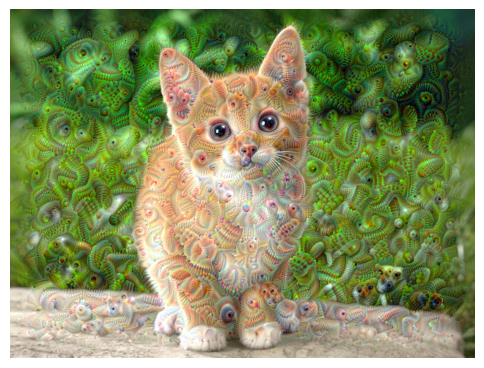

In [ ]:
# Preprocess the original image
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

# Compute shapes for each octave (small → large)
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]  # Smallest first

# Initialize shrunk version of the original image
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])
img = tf.identity(original_img)  # Make a working copy

# Process each octave
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    # Recover lost detail by blending with original
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

# Convert final tensor back to RGB and save
deprocessed_img = deprocess_image(img.numpy())
utils.save_img(path=f"outputs/{result_prefix}.png", x=deprocessed_img)

# Display result
plt.figure(figsize=(6, 6))
plt.imshow(deprocessed_img)
plt.axis("off")
plt.show()